# CVIT Orientation : Problem Statement

Line & Word level segementation in documents is an important task for extracting text ( OCR ) task . 

In the following case , we take a look at different printed documents and try to extract charecter line segment and word level arguments. 

References : 
1.https://pyimagesearch.com/2021/04/28/opencv-morphological-operations/


In [149]:
import os 
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [150]:
PATH_MEDIUM = 'task2_images/test_tamil.jpg'
PATH_LINE_EXAMPLE = 'task2_images/test_sanskrit.png'
PATH_HARDEST = 'task2_images/test.jpeg'

In [151]:
# Idea is to leverage different morphological filters
def textdilationElementWise(binary_image,iterations=3):
  '''
  binary image : text = 1 bg = 0 
  '''
  # Small local kernel that tickens the existing text more closely
  text_kernel = np.ones((3,3))
  dilated_image = cv2.dilate(binary_image,text_kernel,iterations)
  return dilated_image


def rectangledilation(binary_image,H,W,iterations=3):
  '''
  binary image : text = 1 bg = 0 
  '''
  # Small local kernel that tickens the existing text more closely
  rectange_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(H,W)) # to get the desired filters : here the morph_rect kernel of height H and width W
  print("Below is a rectangle kernel")
  plt.imshow (rectange_kernel)
  dilated_image = cv2.dilate(binary_image,rectange_kernel,iterations) # dilate the image using the rectangle kernel created above

  # why rectangle? because we want words

  return dilated_image


def erosionOperation(binary_image,H,W,iterations=3):
  # Small local kernel that erodes vertically
  rectange_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(H,W))
  eroded_image = cv2.erode(binary_image,rectange_kernel,iterations)
  return eroded_image


def crossErosion(binary_image,iterations=2):
  cross_kernel= cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
  cross_eroded_image = cv2.erode(binary_image,cross_kernel,iterations)
  return cross_eroded_image


In [152]:

def binarize_and_word_detect_contours(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale

    blurred = cv2.GaussianBlur(gray, (3, 3), 0)   # Applying Gaussian Blur

    denoised = cv2.fastNlMeansDenoising(blurred, None, h=10, templateWindowSize=7, searchWindowSize=21) # Apply image denoising
    
    _, binary = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY) # Apply binary thresholding


    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs[0][0].imshow(binary)
    axs[0][0].set_title('Binary Image')
    
    
    # print('Thicker text')
    thickTextDocument = textdilationElementWise(255-binary,iterations=5) # text dilation 
    axs[0][1].imshow(thickTextDocument)
    axs[0][1].set_title('Thicker Text')

    # print('Word level dilation')
    wordTextDocument = rectangledilation(thickTextDocument,H=7,W=3,iterations=3)
    axs[1][0].imshow(wordTextDocument)
    axs[1][0].set_title('Word Level Dilation')
    

    # print('Dilation Operation to join cuts within word blobs')
    # closeDocument = textdilationElementWise(wordTextDocument,iterations=3)
    # plt.imshow(closeDocument)

    # print('Cross Kernel Erosion : To further split interline blobs')
    # crossErodedDocument = crossErosion(closeDocument,iterations=3)
    # plt.imshow(crossErodedDocument)

    # Find contours in the binary image
    
    # A CONNECTED COMPONENT IS A CONTOUR
    # mode is RETR_ENTERNAL which retrieves only the extreme outer contours
    # chain_approx_simple is the method to get the contours.
    contours, _ = cv2.findContours(wordTextDocument,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 


    # Filter out the extremely small boxes based on area threshold 
    areaThreshold = 5 # minimum area of the contour is 5
    finalContours = [ c for c in contours if cv2.contourArea(c)>areaThreshold ]
    
    # Draw contours on the original image
    image_with_contours = cv2.drawContours(image.copy(),finalContours, -1, (0, 255, 0), 2)
    image_with_boxes = image.copy()
    for contour in finalContours:
      # Find the bounding box coordinates
      x, y, w, h = cv2.boundingRect(contour)
      # Draw the bounding box on the image
      cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0,0,255),3)

    
    # Display the original image and the image with contours
    # print('Image With Contours')
    axs[1][1].imshow(image_with_boxes)
    axs[1][1].set_title('Image With Contours')
    

    # Save them in the directory 
    _,imgName = os.path.split(image_path)
    cv2.imwrite('wordlevel_contours_'+imgName,image_with_contours)
    cv2.imwrite('wordlevel_boxes_'+imgName,image_with_boxes)



Below is a rectangle kernel


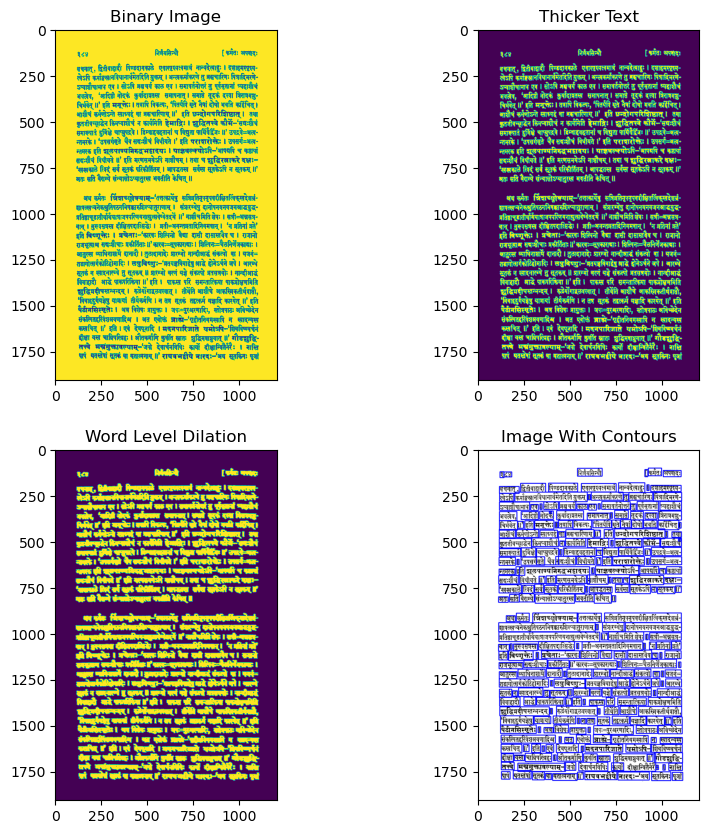

In [153]:
# Usage example
binarize_and_word_detect_contours(PATH_LINE_EXAMPLE)

In [154]:
def binarize_and_line_detect_contours(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply image denoising
    denoised = cv2.fastNlMeansDenoising(blurred, None, h=10, templateWindowSize=7, searchWindowSize=21)
    
    # Apply binary thresholding
    _, binary = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY)

    fig, axs = plt.subplots(2,3, figsize=(15,10))
    
    
    axs[0][0].imshow(binary)
    axs[0][0].set_title('Binary Image')
    # text dilation 
    # print('Thicker text')
    thickTextDocument = textdilationElementWise(255-binary,iterations=5)
    axs[0][1].imshow(thickTextDocument)
    axs[0][1].set_title('Thicker Text')

    # print('Line Level Dilation')

    # search the phrases
    dilatation_type = cv2.MORPH_RECT
    horizontal_dilatation = 5 
    vertical_dilatation = 0
    element = cv2.getStructuringElement(dilatation_type, (2*horizontal_dilatation + 1, 2*vertical_dilatation+1), (horizontal_dilatation, vertical_dilatation))
    dilatation_thresh = cv2.dilate(thickTextDocument,element,iterations=1)

    # Fill
    filled_tresh = dilatation_thresh.copy()
    contours, hierarchy = cv2.findContours(dilatation_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for cnt in contours:
        cv2.drawContours(filled_tresh, [cnt], -1, 255, cv2.FILLED)
    

    # Connect these disconnected blobs further 
    # print('Line level dilation')
    lineTextDocument = rectangledilation(filled_tresh,H=31,W=1,iterations=1)
    axs[0][2].imshow(lineTextDocument)
    axs[0][2].set_title('Line Level Dilation')

    # Cross Filter : Erosion 
    lineTextDocument = crossErosion(lineTextDocument,iterations=10)
    # print('Line erosion')
    axs[1][0].imshow(lineTextDocument)
    axs[1][0].set_title('Line Erosion')
    # Find contours in the binary image
    contours, _ = cv2.findContours(lineTextDocument,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
    # Filter out the extremely small boxes based on area threshold 
    areaThreshold = 1000
    finalContours = [ c for c in contours if cv2.contourArea(c)>areaThreshold ]
    
    # Draw contours on the original image
    image_with_contours = cv2.drawContours(image.copy(),finalContours, -1, (255,0,0),3)
    image_with_boxes = image.copy()

    for contour in finalContours:
      # Find the bounding box coordinates
      x, y, w, h = cv2.boundingRect(contour)
      # Draw the bounding box on the image
      cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0,0,255),3)

    
    # Display the original image and the image with contours
    # print('Image With Contours')
    axs[1][1].imshow(image_with_contours)
    axs[1][1].set_title('Image With Contours')
    

    # Display the original image and the image with contours
    # print('Image With Boxes')
    axs[1][2].imshow(image_with_boxes)
    axs[1][2].set_title('Image With Boxes')

    # # Save them in the directory 
    # _,imgName = os.path.split(image_path)
    # cv2.imwrite('linelevel_contours_'+imgName,image_with_contours)
    # cv2.imwrite('linelevel_boxes_'+imgName,image_with_boxes)


    axs[0][0].label_outer()
    axs[0][1].label_outer()
    axs[0][2].label_outer()
    axs[1][0].label_outer()
    axs[1][1].label_outer()
    axs[1][2].label_outer()
    

Below is a rectangle kernel


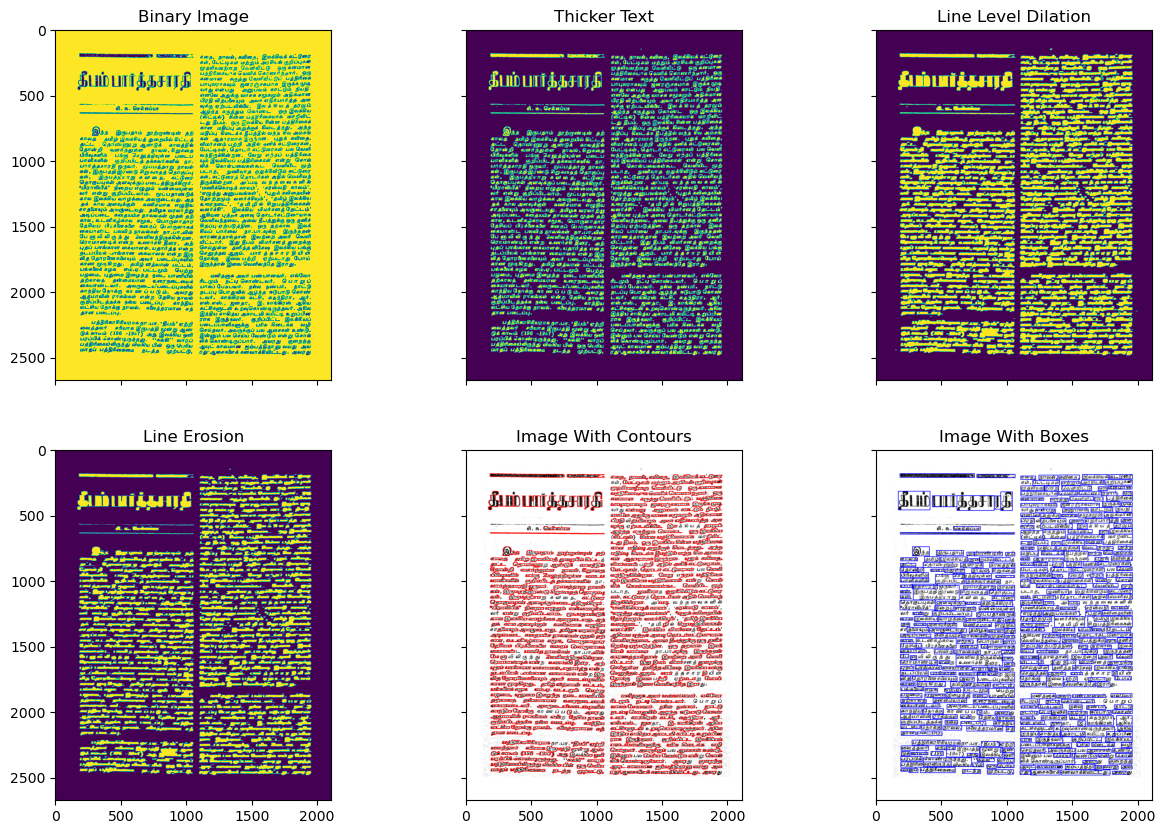

In [155]:
# Usage example ( easy - less dense example )
binarize_and_line_detect_contours('task2_images/test_tamil.jpg')